# FIFA2020 Player Clustering
[Instructions](https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset#players_20.csv)
##### Part A:
Cluster the players to three clusters, and evaluate the clustering without any real labels
##### Part B:
Same as part A but this time having 15% of the labels

## Download data
Run only if players_20.csv is not in folder

In [2]:
!kaggle datasets download -d stefanoleone992/fifa-20-complete-player-dataset
!unzip fifa-20-complete-player-dataset.zip
!rm fifa-20-complete-player-dataset.zip

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
rm: cannot remove `fifa-20-complete-player-dataset.zip': No such file or directory


## Imports

In [7]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score, accuracy_score, confusion_matrix

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Consts

In [8]:
INPUT_PATH = 'players_20.csv'
INDEX_COL = 'sofifa_id'
# As given in the instructions + remoced columns that gives the answer too easily (nation position...)
COLUMNS_TO_DROP = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning',
                  'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
                  'goalkeeping_reflexes', 'goalkeeping_diving', 'team_position', 'player_positions', 'nation_position']

# Columns that looked worthless or encapsulated in other columns 
COLUMNS_TO_DROP_AFTER_INSPECTING = ['short_name', 'long_name', 'nationality', 'club', 'real_face', 'loaned_from', 
                                    'joined', 'contract_valid_until', 'dob', 'international_reputation', 'potential']

# Columns that of the form 'int+int' to be evaluated
COLUMNS_TO_EVAL = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 
                   'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']

TARGET_COL = 'target'

CLUSTER_NUMBER = 3 # Attacking, midfieled or defensive
ITERATION_MAX = 100
DEF_THRESHOLD = 0.8
RANDOM_SEED = 6
PART_B_SEED = 4
PART_B_LABELED_SIZE = 0.15
TRAIN_SIZE = 0.5 # For semi-sup learning

In [9]:
preferred_foot_vals = {
    'Left' : 0,
    'Right' : 1
}

body_type_vals = {
    'Lean' : 1,
    'Normal' : 2,
    'Stocky' : 3,
    'Neymar' : 1,
    'C. Ronaldo' : 2,
    'Shaqiri' : 3,
    'Messi' : 1,
    'Akinfenwa' : 3, # suuuper big
    'PLAYER_BODY_TYPE_25' : 2 # M. Salah
}

work_rate_vals = {
    'Low' : 1,
    'Medium' : 2,
    'High' : 3
}

position_dict = {
    'RW':'ST', 'LW':'ST', 'CAM':'ST', 'ST':'ST', 'RM':'ST', 
    'LM':'ST', 'CF':'ST', 'LS':'ST', 'RES':'ST', 'RAM':'ST',
    'RS': 'ST', 'RF':'ST', 'LF':'ST', 'LAM':'ST', 'RCM':'B',
    'LCM':'B', 'RCB':'B', 'LCB':'B', 'CB':'B', 'CDM':'MD',
    'LDM':'MD', 'LB':'MD', 'RB':'MD', 'RDM':'MD', 'CM':'MD',
    'RWB':'MD', 'LWB':'MD'
}

## Functions

In [10]:
# Semi supervised learning related
# CR - beware of setting with coppy wraning / changing the data inside the function.
#      in addition, I would consider taking the first n_th percentile for the 
#      training to keep improving yourself. Yours is the common way for self training.

def self_learning(model, X_train, y_train, unlabeled_df, iterations=ITERATION_MAX, conf_thresh=DEF_THRESHOLD):
    """
    Perform self trainig in a given model
    NOTE: Modify X_train, y_train and labeled_df
    NOTE: Stuff here are data specific so... no ctrl+c ctrl+v
    
    Parameters:
    model : object with fit and predict_proba mathods
        The model to self train
    X_train : np.array
        data that has labels
    y_train : pd.series
        labels for X_train
    unlabeled_df : pd.DataFrame
        unlabeled data
    
    Returns
    -------
    model : model after being fit
    """
    
    for i in range(iterations):
        model.fit(X_train, y_train)
        pred_probas = model.predict_proba(unlabeled_df)
        pred_proba_df = pd.DataFrame(model.predict_proba(unlabeled_df), 
                                     index=unlabeled_df.index, 
                                     columns=['B','MD','ST'])
        pred_proba_df['pred'] = pred_proba_df.idxmax(axis=1)

        # Add predictions with high confidence to the labeled data
        conf_preds = pred_proba_df.loc[(pred_proba_df.B > conf_thresh)|
                                       (pred_proba_df.MD > conf_thresh)|
                                       (pred_proba_df.ST > conf_thresh), 'pred']

        previous_labeled_num = len(X_train)
        
        X_train = X_train.append(unlabeled_df.loc[conf_preds.index])
        y_train = y_train.append(conf_preds)

        unlabeled_df.drop(index=conf_preds.index,inplace=True)
        
        # If no new confident predictions, return
        if len(X_train) == previous_labeled_num:
            return model
    
    return model

## Read and Parse Data

### Read

In [11]:
df = pd.read_csv(INPUT_PATH, index_col=INDEX_COL)
df[TARGET_COL] = [possible_positions.split(', ')[0] for possible_positions in df['player_positions']]
df = df.drop(df.loc[(df[TARGET_COL] == 'GK') | (df[TARGET_COL].isna())].index, axis=0) # Drop goalkeepers
df = df.drop(COLUMNS_TO_DROP, axis=1)

# Set index to be the URL (more informative than index and still unique) - CR - index is better
df.set_index('player_url', inplace=True)

target_vals = df[TARGET_COL] # For second part
df = df.drop(TARGET_COL, axis=1)
df.head()

short_name  \
player_url                                                              
https://sofifa.com/player/158023/lionel-messi/2...           L. Messi   
https://sofifa.com/player/20801/c-ronaldo-dos-s...  Cristiano Ronaldo   
https://sofifa.com/player/190871/neymar-da-silv...          Neymar Jr   
https://sofifa.com/player/183277/eden-hazard/20...          E. Hazard   
https://sofifa.com/player/192985/kevin-de-bruyn...       K. De Bruyne   

                                                                              long_name  \
player_url                                                                                
https://sofifa.com/player/158023/lionel-messi/2...       Lionel Andrés Messi Cuccittini   
https://sofifa.com/player/20801/c-ronaldo-dos-s...  Cristiano Ronaldo dos Santos Aveiro   
https://sofifa.com/player/190871/neymar-da-silv...        Neymar da Silva Santos Junior   
https://sofifa.com/player/183277/eden-hazard/20...                          Eden Hazard   
https://sofifa.com/player/192985/kevin-de-bruyn...                      Kevin De Bruyne   

                                                    age         dob  \
player_url                                                            
https://sofifa.com/player/158023/lionel-messi/2...   32  1987-06-24   
https://sofifa.com/player/20801/c-ronaldo-dos-s...   34  1985-02-05   
https://sofifa.com/player/190871/neymar-da-silv...   27  1992-02-05   
https://sofifa.com/player/183277/eden-hazard/20...   28  1991-01-07   
https://sofifa.com/player/192985/kevin-de-bruyn...   28  1991-06-28   

                                                    height_cm  weight_kg  \
player_url                                                                 
https://sofifa.com/player/158023/lionel-messi/2...        170         72   
https://sofifa.com/player/20801/c-ronaldo-dos-s...        187         83   
https://sofifa.com/player/190871/neymar-da-silv...        175         68   
https://sofifa.com/player/183277/eden-hazard/20...        175         74   
https://sofifa.com/player/192985/kevin-de-bruyn...        181         70   

                                                   nationality  \
player_url                                                       
https://sofifa.com/player/158023/lionel-messi/2...   Argentina   
https://sofifa.com/player/20801/c-ronaldo-dos-s...    Portugal   
https://sofifa.com/player/190871/neymar-da-silv...      Brazil   
https://sofifa.com/player/183277/eden-hazard/20...     Belgium   
https://sofifa.com/player/192985/kevin-de-bruyn...     Belgium   

                                                                   club  \
player_url                                                                
https://sofifa.com/player/158023/lionel-messi/2...         FC Barcelona   
https://sofifa.com/player/20801/c-ronaldo-dos-s...             Juventus   
https://sofifa.com/player/190871/neymar-da-silv...  Paris Saint-Germain   
https://sofifa.com/player/183277/eden-hazard/20...          Real Madrid   
https://sofifa.com/player/192985/kevin-de-bruyn...      Manchester City   

                                                    overall  potential  ...  \
player_url                                                              ...   
https://sofifa.com/player/158023/lionel-messi/2...       94         94  ...   
https://sofifa.com/player/20801/c-ronaldo-dos-s...       93         93  ...   
https://sofifa.com/player/190871/neymar-da-silv...       92         92  ...   
https://sofifa.com/player/183277/eden-hazard/20...       91         91  ...   
https://sofifa.com/player/192985/kevin-de-bruyn...       91         91  ...   

                                                     lwb   ldm   cdm   rdm  \
player_url                                                                   
https://sofifa.com/player/158023/lionel-messi/2...  68+2  66+2  66+2  66+2   
https://sofifa.com/player/20801/c-ronaldo-dos-s...  65+3  61+3  61+3  61+3   
https://sofifa.com/play

In [12]:
# Currenty, alot of columns exist but won't help us (call it domain knowledge...)

# Removing colunms that contains data that can be inferred/affected by other columns
# Removing columns that probably have no special value
df = df.drop(COLUMNS_TO_DROP_AFTER_INSPECTING, axis=1)

### Parse

In [14]:
# Needs special processing (after searching online, looking at the values...)

# evaluate columns that have a base value and a reputation bonus
df[COLUMNS_TO_EVAL] = df[COLUMNS_TO_EVAL].apply(np.vectorize(eval))

# work_rate has the form attcking_work_rate/defensive_work_rate - split to two features and transform to numeric
work_rates_df = df.work_rate.str.split('/', expand=True) # CR - great
df['attacking_work_rate'] = work_rates_df[0]
df['defensive_work_rate'] = work_rates_df[1]
df = df.drop('work_rate', axis=1)

# Get features from player's uniqe attributes (dribbler, long shooter...)
df.player_tags = df.player_tags.fillna("").str.split(", ")
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('player_tags')),
                          columns=mlb.classes_,
                          index=df.index))
df = df.drop('', axis=1)

# Get features from player's uniqe traits (leader, diver...)
df.player_traits = df.player_traits.fillna("").str.split(", ")
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('player_traits')),
                          columns=mlb.classes_,
                          index=df.index))
df = df.drop('', axis=1)
# CR - great code

# Turn categorical to numeric (when it is logical)
df.body_type.replace(body_type_vals, inplace=True)
df.preferred_foot.replace(preferred_foot_vals, inplace=True)
df.attacking_work_rate.replace(work_rate_vals, inplace=True)
df.defensive_work_rate.replace(work_rate_vals, inplace=True)


# Fill na with values that looks fine to me
df.release_clause_eur.fillna(0, inplace=True) # No release clause -> can be signed by another team...
df.team_jersey_number.fillna(df.nation_jersey_number, inplace=True) # No player with both numbers missing
df = df.drop('nation_jersey_number', axis=1) # Most players aren't playing in their national team

# Turning floats to ints (after checking they are ints in the shape of floats... (X.0))
float_cols =  ['release_clause_eur', 'team_jersey_number', 'pace', 
               'shooting', 'passing', 'dribbling', 'defending', 'physic']

df[float_cols] = df[float_cols].astype(int)

### Normalize 

In [15]:
# Divide position scores by overall score
df[COLUMNS_TO_EVAL] = df[COLUMNS_TO_EVAL].div(df['overall'], axis=0)#.isna()


In [16]:
# Other normalizations, worked worse

# df=(df-df.min())/(df.max()-df.min())
df=(df-df.mean())/(df.std()) # Z-scores.. not in range of (-1,1)

## Creating Different datasets

NOTE: t-SNE takes ~3min and is not necessary for the rest of the notebook..

### PCA

In [18]:
pca = PCA(n_components=20, random_state=RANDOM_SEED)
pca_data = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_data,index=df.index, 
                      columns=[f'c{i}' for i in range(1, pca.n_components+1)])

pca.explained_variance_ratio_
px.line(x=pca_df.columns, y=pca.explained_variance_ratio_)

# CR - graph titles + turn to CDF and not PDF

### t-SNE

In [154]:
tsne = TSNE(n_components=3, random_state=RANDOM_SEED)
tsne_data = tsne.fit_transform(df)
tsne_df = pd.DataFrame(tsne_data,index=df.index, 
                       columns=[f'c{i}' for i in range(1, tsne.n_components+1)])

### Sub Datasets

In [19]:
tags = ['#Acrobat', '#Aerial Threat' ,'#Clinical Finisher', '#Complete Defender', 
        '#Complete Forward', '#Complete Midfielder', '#Crosser', '#Distance Shooter', 
        '#Dribbler', '#Engine', '#FK Specialist', '#Playmaker\xa0 ', '#Poacher',  '#Speedster', 
        '#Strength', '#Tackling\xa0', '#Tactician\xa0']

tags_df = df[tags]

traits = ['1-on-1 Rush', 'Argues with Officials', 'Avoids Using Weaker Foot', 
          'Beat Offside Trap', 'Crowd Favourite', 'Diver', 'Dives Into Tackles (CPU AI Only)', 
          'Early Crosser', 'Finesse Shot', 'Giant Throw-in', 'Inflexible', 'Injury Free', 
          'Injury Prone', 'Leadership', 'Long Passer (CPU AI Only)', 
          'Long Shot Taker (CPU AI Only)', 'Long Throw-in', 'Outside Foot Shot', 
          'Power Free-Kick', 'Selfish', 'Skilled Dribbling', 'Speed Dribbler (CPU AI Only)']
traits_df = df[traits]

positions_scores = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 
                    'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 
                    'cb', 'rcb', 'rb']
positions_scores_df = df[positions_scores]

general_player_scores = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
general_player_scores_df = df[general_player_scores]

general_player_details = ['age', 'height_cm', 'weight_kg', 'overall', 'value_eur', 'wage_eur', 
                          'preferred_foot', 'weak_foot', 'skill_moves', 'body_type', 
                          'release_clause_eur', 'team_jersey_number']
general_player_details_df = df[general_player_details]

## Clustering

In [20]:
# What df to use and how to visualize results
chosen_df = positions_scores_df
dim_reduction_for_plot = "PCA"

In [22]:
kmeans = KMeans(n_clusters=CLUSTER_NUMBER, random_state=RANDOM_SEED)
# CR - I wouldn't insert a model parameter from a constant.... it might change
res = kmeans.fit_predict(chosen_df)

In [23]:
if dim_reduction_for_plot == 'PCA':
    dim_red = PCA(n_components=2, random_state=RANDOM_SEED)
elif dim_reduction_for_plot == 'TSNE':
    dim_red = TSNE(n_components=2, random_state=RANDOM_SEED)
dim_red_data = dim_red.fit_transform(chosen_df)
dim_red_df = pd.DataFrame(dim_red_data,index=chosen_df.index, 
                      columns=[f'c{i}' for i in range(1, dim_red.n_components+1)])
dim_red_df['cluster'] = res

In [24]:
fig = px.scatter(dim_red_df, x='c1', y='c2', color='cluster', hover_name=dim_red_df.index)
fig.update_layout(title=f"Data after dimention reduction ({dim_reduction_for_plot})")
fig.show()

In [25]:
print(f"sil score = {silhouette_score(chosen_df, res)}")

sil score = 0.529033000273305


In [26]:
pd.value_counts(res)

0    7555
1    5623
2    3064
dtype: int64

## Semi Supervised

In [27]:
updated_target = target_vals.replace(position_dict)
pd.value_counts(updated_target)

ST    6687
MD    6393
B     3162
Name: target, dtype: int64

In [28]:
# Take only train parts
X_available, X_unavailable, y_available, y_unavailable = train_test_split(chosen_df.copy(), 
                                                                          updated_target, 
                                                                          train_size=PART_B_LABELED_SIZE, 
                                                                          random_state=PART_B_SEED)


# chosen_df.loc[:,'real'] = pd.Series(index=chosen_df.index, data=y_available)
# chosen_df.loc[:,'pred'] = pd.Series(index=chosen_df.index, data=res)

data_labels_preds = pd.DataFrame([y_available, pd.Series(index=chosen_df.index, data=res, name='pred')]).transpose()


### Using labeled for better metrics

In [29]:
# Get score using the labeled data
labeled_results = data_labels_preds.dropna()
ami_score = adjusted_mutual_info_score(labeled_results['target'], labeled_results['pred'])
print(f"adjusted MI score on the labeled data = {ami_score}")

adjusted MI score on the labeled data = 0.6323662042651463


In [30]:
# Confusion matrix, kind of
labeled_results = labeled_results.replace({'ST':1,'MD':0,'B':2})

acc_score = accuracy_score(list(labeled_results.target), list(labeled_results.pred))
print(f"Accuracy score using 15% labeled data = {acc_score}")

Accuracy score using 15% labeled data = 0.8711001642036125


Text(33.0, 0.5, 'Real')

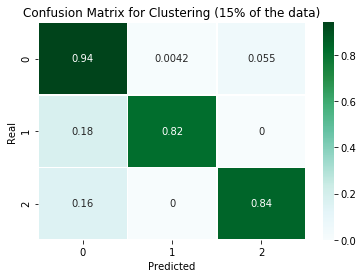

In [31]:
sns.heatmap(confusion_matrix(y_true=list(labeled_results.target), 
                             y_pred=list(labeled_results.pred),
                             normalize='true'),
           linewidths=0.5,
           cmap="BuGn",
           annot=True)
plt.title("Confusion Matrix for Clustering (15% of the data)")
plt.xlabel("Predicted")
plt.ylabel("Real")
# Horizontal - predicted, vertical - real

# CR - matplotlib notebook or at least a bigger figure

### Using some labels for self training and others to evaluate

In [32]:
labeled_df = X_available.copy()

unlabeled_df = X_unavailable.copy()

# Take only train parts for the initial dataset
X_train, X_val, y_train, y_val = train_test_split(labeled_df, 
                                                  y_available, 
                                                  train_size=TRAIN_SIZE, 
                                                  random_state=PART_B_SEED)


from sklearn.semi_supervised import LabelPropagation

model = LabelPropagation()
model.fit(labeled_df.append(unlabeled_df), 
          pd.Series(index=chosen_df.index, data=y_available).replace({'ST':0,
                                                                      'MD':1,
                                                                      'B':2}).fillna(-1))
pred = np.array(model.predict(X_val))
print(f"accuracy = {accuracy_score(y_val.replace({'ST':0,'MD':1,'B':2}), pred)}")

C:\Users\jonka\AppData\Roaming\Python\Python37\site-packages\sklearn\semi_supervised\_label_propagation.py:292: ConvergenceWarning:

max_iter=1000 was reached without convergence.



accuracy = 0.36288998357963875


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
# My implementation of self learning

labeled_df = X_available.copy()
unlabeled_df = X_unavailable.copy()

# Take only train parts for the initial dataset
X_train, X_val, y_train, y_val = train_test_split(labeled_df, 
                                                  y_available, 
                                                  train_size=TRAIN_SIZE, 
                                                  random_state=PART_B_SEED)


model = RandomForestClassifier(max_depth=10, n_estimators=100)
eps = 0.75 # confident enough
fitted_model = self_learning(model, X_train, y_train, unlabeled_df, conf_thresh=eps)
preds = fitted_model.predict(X_val)
accuracy_score(preds, y_val)

0.9408866995073891

Text(33.0, 0.5, 'Real')

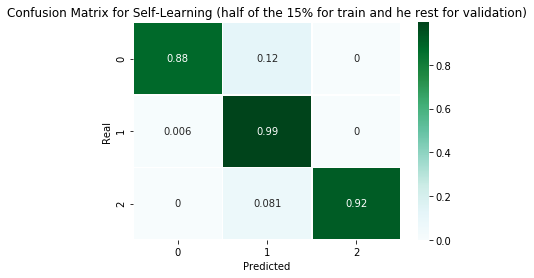

In [41]:
sns.heatmap(confusion_matrix(y_true=y_val, 
                             y_pred=preds,
                             normalize='true'),
           linewidths=0.5,
           cmap="BuGn",
           annot=True)

plt.title("Confusion Matrix for Self-Learning (half of the 15% for train and he rest for validation)")
plt.xlabel("Predicted")
plt.ylabel("Real")

## Fifa 19 scores
Got formula to clculate each position's overall score. Can use features and overall score to see what formula used-> get position

In [24]:
raw_df = pd.read_csv(INPUT_PATH, index_col='player_url')
reputations = raw_df['international_reputation']

### Calculate Scores per Position

In [178]:
# Defensive positions
cb_score = pd.Series(index=raw_df.index, 
                     data=[0.15*raw_df.defending_marking
                           +0.15*raw_df.defending_standing_tackle
                           +0.15*raw_df.defending_sliding_tackle
                           +0.1*raw_df.attacking_heading_accuracy
                           +0.1*raw_df.power_strength
                           +0.08*raw_df.mentality_aggression
                           +0.08*raw_df.mentality_interceptions
                           +0.05*raw_df.attacking_short_passing
                           +0.05*raw_df.skill_ball_control
                           +0.05*raw_df.movement_reactions
                           +0.04*raw_df.power_jumping][0],
                     dtype=int, name="cb")

rb_score = pd.Series(index=raw_df.index, 
                      data=[0.13*raw_df.defending_sliding_tackle
                            +0.12*raw_df.defending_standing_tackle
                            +0.12*raw_df.mentality_interceptions
                            +0.1*raw_df.power_stamina
                            +0.08*raw_df.power_stamina
                            +0.08*raw_df.movement_reactions
                            +0.07*raw_df.attacking_crossing
                            +0.07*raw_df.attacking_heading_accuracy
                            +0.07*raw_df.skill_ball_control
                            +0.06*raw_df.attacking_short_passing
                            +0.05*raw_df.movement_sprint_speed
                            +0.05*raw_df.mentality_aggression][0],
                      dtype=int, name="rb")

rwb_score = pd.Series(index=raw_df.index, 
                      data=[0.11*raw_df.defending_standing_tackle
                            +0.1*raw_df.defending_sliding_tackle
                            +0.1*raw_df.attacking_crossing
                            +0.1*raw_df.attacking_short_passing
                            +0.1*raw_df.skill_ball_control
                            +0.1*raw_df.mentality_interceptions
                            +0.09*raw_df.defending_marking
                            +0.08*raw_df.power_stamina
                            +0.08*raw_df.movement_reactions
                            +0.07*raw_df.skill_dribbling
                            +0.04*raw_df.movement_sprint_speed
                            +0.03*raw_df.mentality_aggression][0],
                      dtype=int, name="rwb")

In [179]:
# Midfield positions
cdm_score = pd.Series(index=raw_df.index, 
                      data=[0.13*raw_df.attacking_short_passing
                            +0.12*raw_df.mentality_interceptions
                            +0.11*raw_df.skill_long_passing
                            +0.1*raw_df.defending_marking
                            +0.1*raw_df.defending_standing_tackle
                            +0.09*raw_df.skill_ball_control
                            +0.09*raw_df.movement_reactions
                            +0.08*raw_df.mentality_vision
                            +0.06*raw_df.power_stamina
                            +0.06*raw_df.power_strength
                            +0.04*raw_df.mentality_aggression][0],
                      dtype=int, name="cdm")

cm_score = pd.Series(index=raw_df.index,
                     data=[0.15*raw_df.attacking_short_passing
                           +0.13*raw_df.skill_long_passing
                           +0.12*raw_df.mentality_vision
                           +0.1*raw_df.skill_ball_control
                           +0.09*raw_df.skill_dribbling
                           +0.08*raw_df.movement_reactions
                           +0.08*raw_df.mentality_interceptions
                           +0.08*raw_df.mentality_positioning
                           +0.06*raw_df.defending_standing_tackle
                           +0.06*raw_df.power_stamina
                           +0.05*raw_df.power_long_shots][0],
                      dtype=int, name="cm")

cam_score = pd.Series(index=raw_df.index,
                      data=[0.16*raw_df.attacking_short_passing
                            +0.16*raw_df.mentality_vision
                            +0.13*raw_df.skill_ball_control
                            +0.12*raw_df.mentality_positioning
                            +0.11*raw_df.skill_dribbling
                            +0.08*raw_df.movement_reactions
                            +0.06*raw_df.power_long_shots
                            +0.05*raw_df.attacking_finishing
                            +0.05*raw_df.power_shot_power
                            +0.04*raw_df.movement_acceleration
                            +0.04*raw_df.movement_agility][0],
                      dtype=int, name="cam")

In [180]:
# Wingers
rm_score = pd.Series(index=raw_df.index,
                     data=[0.14*raw_df.attacking_crossing
                           +0.14*raw_df.skill_dribbling
                           +0.12*raw_df.attacking_short_passing
                           +0.12*raw_df.skill_ball_control
                           +0.08*raw_df.skill_long_passing
                           +0.08*raw_df.mentality_vision
                           +0.07*raw_df.movement_reactions
                           +0.07*raw_df.mentality_positioning
                           +0.05*raw_df.power_stamina
                           +0.05*raw_df.movement_acceleration
                           +0.05*raw_df.movement_sprint_speed
                           +0.03*raw_df.movement_agility][0],
                      dtype=int, name="rm")

rw_score = pd.Series(index=raw_df.index,
                     data=[0.16*raw_df.attacking_crossing
                           +0.12*raw_df.attacking_short_passing
                           +0.11*raw_df.skill_dribbling
                           +0.11*raw_df.skill_ball_control
                           +0.1*raw_df.power_shot_power
                           +0.1*raw_df.power_long_shots
                           +0.1*raw_df.movement_reactions
                           +0.06*raw_df.attacking_short_passing
                           +0.05*raw_df.attacking_heading_accuracy
                           +0.05*raw_df.mentality_vision
                           +0.04*raw_df.movement_acceleration
                           +0.04*raw_df.movement_sprint_speed][0],
                      dtype=int, name="rw")

In [181]:
# Strikers
cf_score = pd.Series(index=raw_df.index,
                     data=[0.12*raw_df.attacking_finishing
                           +0.12*raw_df.attacking_short_passing
                           +0.11*raw_df.skill_dribbling
                           +0.11*raw_df.skill_ball_control
                           +0.1*raw_df.power_shot_power
                           +0.1*raw_df.power_long_shots
                           +0.1*raw_df.movement_reactions
                           +0.06*raw_df.attacking_short_passing
                           +0.05*raw_df.attacking_heading_accuracy
                           +0.05*raw_df.mentality_vision
                           +0.04*raw_df.movement_acceleration
                           +0.04*raw_df.movement_sprint_speed][0],
                      dtype=int, name="cf")

st_score = pd.Series(index=raw_df.index,
                     data=[0.2*raw_df.attacking_finishing
                           +0.12*raw_df.mentality_positioning
                           +0.1*raw_df.attacking_heading_accuracy
                           +0.1*raw_df.power_shot_power
                           +0.1*raw_df.movement_reactions
                           +0.08*raw_df.skill_dribbling
                           +0.08*raw_df.skill_ball_control
                           +0.05*raw_df.attacking_volleys
                           +0.05*raw_df.power_long_shots
                           +0.05*raw_df.movement_acceleration
                           +0.04*raw_df.movement_sprint_speed
                           +0.03*raw_df.power_strength][0],
                      dtype=int, name="st")

In [196]:
position_scores_df = pd.DataFrame(data=[cb_score, rb_score, rwb_score,
                                        cdm_score, cm_score, cam_score, 
                                        rm_score, rw_score, cf_score, st_score]).transpose()
# Since international reputation adds to all position score, will ignore that
position_scores_df.head()

cb  rb  rwb  cdm  cm  cam  \
player_url                                                                      
https://sofifa.com/player/158023/lionel-messi/2...  52  63   66   69  85   93   
https://sofifa.com/player/20801/c-ronaldo-dos-s...  54  64   63   64  78   89   
https://sofifa.com/player/190871/neymar-da-silv...  46  62   64   63  80   90   
https://sofifa.com/player/200389/jan-oblak/20/1...  33  31   30   40  36   39   
https://sofifa.com/player/183277/eden-hazard/20...  48  62   64   66  80   89   

                                                    rm  rw  cf  st  
player_url                                                          
https://sofifa.com/player/158023/lionel-messi/2...  91  94  91  89  
https://sofifa.com/player/20801/c-ronaldo-dos-s...  87  92  90  92  
https://sofifa.com/player/190871/neymar-da-silv...  89  91  87  84  
https://sofifa.com/player/200389/jan-oblak/20/1...  36  38  37  31  
https://sofifa.com/player/183277/eden-hazard/20...  88  89  86  83

### Use Scores to get Natural Position

In [198]:
# take the FIRST best position
position_scores_df['natural_pos'] = position_scores_df.idxmax(axis=1)
pd.value_counts(position_scores_df['natural_pos'])

rw     4986
cb     4442
rb     2309
st     1852
rm     1746
cam    1225
cdm    1026
cm      366
rwb     238
cf       88
Name: natural_pos, dtype: int64